<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Evaluation

Evaluation with offline metrics is pivotal to assess the quality of a recommender before it goes into production. Usually, evaluation metrics are carefully chosen based on the actual application scenario of a recommendation system. It is hence important to data scientists and AI developers that build recommendation systems to understand how each evaluation metric is calculated and what it is for.

This notebook deep dives into several commonly used evaluation metrics, and illustrates how these metrics are used in practice. The metrics covered in this notebook are merely for off-line evaluations.

## 0 Global settings

Most of the functions used in the notebook can be found in the `reco_utils` directory.

In [84]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [98]:
# set the environment path to find Recommenders
import sys
sys.path.append("../../")
import math
import time

import cudf as cu
import numpy as np
import pandas as pd

from reco_utils.common.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
)
from reco_utils.common.plot import bar_chart
# from reco_utils.common import plot
from reco_utils.dataset import movielens
from reco_utils.dataset.pandas_df_utils import user_item_pairs
from reco_utils.dataset.python_splitters import python_random_split
import reco_utils.evaluation.python_evaluation as pd_evaluator
import reco_utils.evaluation.rapids_evaluation as cu_evaluator

print("Pandas version: {}".format(pd.__version__))
print("CuDF version: {}".format(cu.__version__))

Pandas version: 0.24.2
CuDF version: 0.8.0+0.g8fa7bd3.dirty


Note to successfully run Spark codes with the Jupyter kernel, one needs to correctly set the environment variables of `PYSPARK_PYTHON` and `PYSPARK_DRIVER_PYTHON` that point to Python executables with the desired version. Detailed information can be found in the setup instruction document [SETUP.md](../../SETUP.md).

In [45]:
MOVIELENS_DATA_SIZE = '100k'

## 1 Prepare data

### 1.1 Prepare dummy data

For illustration purpose, a dummy data set is created for demonstrating how different evaluation metrics work. 

The data has the schema that can be frequently found in a recommendation problem, that is, each row in the dataset is a (user, item, rating) tuple, where "rating" can be an ordinal rating score (e.g., discrete integers of 1, 2, 3, etc.) or an numerical float number that quantitatively indicates the preference of the user towards that item. 

For simplicity reason, the column of rating in the dummy dataset we use in the example represent some ordinal ratings.

In [46]:
pd_data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=[USER_COL, ITEM_COL, RATING_COL],
)
pd_data.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 21.1kKB/s]


,userID,itemID,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


In [47]:
items = pd_data.drop_duplicates(ITEM_COL)[[ITEM_COL]].reset_index(drop=True)
users = pd_data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

pd_pred = user_item_pairs(
    user_df=users,
    item_df=items,
    user_col=USER_COL,
    item_col=ITEM_COL,
)
pd_pred[PREDICT_COL] = 3.0

pd_pred.head()

,userID,itemID,prediction
0,309,514,3.0
1,842,380,3.0
2,110,1620,3.0
3,435,820,3.0
4,920,1285,3.0


In [50]:
print(
    "Num data = {}\n"
    "Num items = {}\n"
    "Num users = {}\n"
    "Num predictions = {}".format(len(pd_data), len(items), len(users), len(pd_pred))
)

Num data = 100000
Num items = 1682
Num users = 943
Num predictions = 1586126


In [61]:
cu_data = cu.from_pandas(pd_data)
cu_pred = cu.from_pandas(pd_pred)

## 2 Evaluation metrics

In [62]:
cols = {
    "col_user": USER_COL,
    "col_item": ITEM_COL,
    "col_rating": RATING_COL,
    "col_prediction": PREDICT_COL,
}

### 2.1 Rating metrics

In [63]:
DEFAULT_USER_COL = USER_COL
DEFAULT_ITEM_COL = ITEM_COL
DEFAULT_RATING_COL = RATING_COL
DEFAULT_PREDICTION_COL = PREDICT_COL

TOL = 0.0001

In [64]:
def rating_true():
    return cu.DataFrame(
        [
            (DEFAULT_USER_COL, [1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
            (DEFAULT_ITEM_COL, [
                1,
                2,
                3,
                1,
                4,
                5,
                6,
                7,
                2,
                5,
                6,
                8,
                9,
                10,
                11,
                12,
                13,
                14,
            ]),
            (DEFAULT_RATING_COL, [5, 4, 3, 5, 5, 3, 3, 1, 5, 5, 5, 4, 4, 3, 3, 3, 2, 1]),
        ]
    )

def rating_pred():
    return cu.DataFrame(
        [
            (DEFAULT_USER_COL, [1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
            (DEFAULT_ITEM_COL, [
                3,
                10,
                12,
                10,
                3,
                5,
                11,
                13,
                4,
                10,
                7,
                13,
                1,
                3,
                5,
                2,
                11,
                14,
            ]),
            (DEFAULT_PREDICTION_COL, [
                14,
                13,
                12,
                14,
                13,
                12,
                11,
                10,
                14,
                13,
                12,
                11,
                10,
                9,
                8,
                7,
                6,
                5,
            ]),
            (DEFAULT_RATING_COL, [5, 4, 3, 5, 5, 3, 3, 1, 5, 5, 5, 4, 4, 3, 3, 3, 2, 1]),
        ]
    )

#### 2.1.1 Root Mean Square Error (RMSE)

In [90]:
start = time.time()
pd_rmse = pd_evaluator.rmse(pd_data, pd_pred, **cols)
pd_rmse_time = time.time() - start
print("RMSE with Pandas = {}, took {} seconds".format(pd_rmse, pd_rmse_time))

RMSE with Pandas = 1.244138255982831, took 2.2447681427001953 seconds


In [91]:
start = time.time()
cu_rmse = cu_evaluator.rmse(cu_data, cu_pred, **cols)
cu_rmse_time = time.time() - start
print("RMSE with Rapids.cuDF = {}, took {} seconds".format(cu_rmse, cu_rmse_time))

RMSE with Rapids.cuDF = 1.244138255982831, took 0.008769989013671875 seconds


In [92]:
assert math.isclose(pd_rmse, cu_rmse, rel_tol=1e-06, abs_tol=1e-06)

#### 2.1.2 Mean Absolute Error (MAE)

In [93]:
start = time.time()
pd_mae = pd_evaluator.mae(pd_data, pd_pred, **cols)
pd_mae_time = time.time() - start
print("MAE with Pandas = {}, took {} seconds".format(pd_mae, pd_mae_time))

MAE with Pandas = 1.00166, took 2.210644006729126 seconds


In [94]:
start = time.time()
cu_mae = cu_evaluator.mae(cu_data, cu_pred, **cols)
cu_mae_time = time.time() - start
print("MAE with Rapids.cuDF = {}, took {} seconds".format(cu_mae, cu_mae_time))

MAE with Rapids.cuDF = 1.00166, took 0.008417367935180664 seconds


In [95]:
assert math.isclose(pd_mae, cu_mae, rel_tol=1e-06, abs_tol=1e-06)

#### 2.1.3 Summary

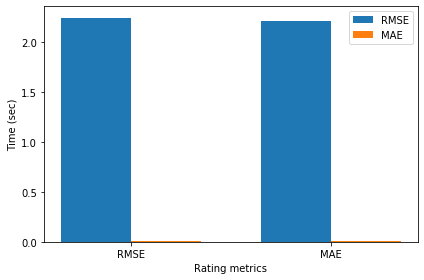

In [100]:
values = [
    [pd_rmse_time, pd_mae_time],
    [cu_rmse_time, cu_mae_time]
]
labels = ['RMSE', 'MAE']

bar_chart(values, labels, errors=None, x_name="Rating metrics", y_name="Time (sec)")

### 2.2 Ranking metrics

#### 2.2.1 Precision

In [16]:
print("The precision at k is {}".format(spark_rank_eval.precision_at_k()))

The precision at k is 0.3333333333333333


#### 2.2.2 Recall

In [17]:
print("The recall at k is {}".format(spark_rank_eval.recall_at_k()))

The recall at k is 0.2111111111111111


#### 2.2.3 Normalized Discounted Cumulative Gain (NDCG)

In [18]:
print("The ndcg at k is {}".format(spark_rank_eval.ndcg_at_k()))

The ndcg at k is 0.3333333333333333


#### 2.2.4 Mean Average Precision (MAP)

In [19]:
print("The map at k is {}".format(spark_rank_eval.map_at_k()))

The map at k is 0.15


#### 2.2.5 Summary

|Metric|Range|Selection criteria|Limitation|Reference|
|------|-------------------------------|---------|----------|---------|
|Precision|$\geq 0$ and $\leq 1$|The closer to $1$ the better.|Only for hits in recommendations.|[link](https://spark.apache.org/docs/2.3.0/mllib-evaluation-metrics.html#ranking-systems)|
|Recall|$\geq 0$ and $\leq 1$|The closer to $1$ the better.|Only for hits in the ground truth.|[link](https://en.wikipedia.org/wiki/Precision_and_recall)|
|NDCG|$\geq 0$ and $\leq 1$|The closer to $1$ the better.|Does not penalize for bad/missing items, and does not perform for several equally good items.|[link](https://spark.apache.org/docs/2.3.0/mllib-evaluation-metrics.html#ranking-systems)|
|MAP|$\geq 0$ and $\leq 1$|The closer to $1$ the better.|Depend on variable distributions.|[link](https://spark.apache.org/docs/2.3.0/mllib-evaluation-metrics.html#ranking-systems)|
|AUC|$\geq 0$ and $\leq 1$|The closer to $1$ the better. 0.5 indicates an uninformative classifier|Depend on the number of recommended items (k).|[link](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve)|
|Logloss|$0$ to $\infty$|The closer to $0$ the better.|Logloss can be sensitive to imbalanced datasets.|[link](https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_log-likelihood)|